In [14]:
import os
import os.path
import PIL
from PIL import Image
import cv2
import random
import numpy as np
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from sklearn.preprocessing import LabelBinarizer
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization

In [2]:
local_tgz = 'lfw-deepfunneled'

In [3]:
lfw_list = [os.path.join(dp, f) for dp, dn, filenames in os.walk(local_tgz) for f in filenames if os.path.splitext(f)[1] == '.jpg']

In [4]:
random.seed(167)
random.shuffle(lfw_list)
lfw_cut = lfw_list[:7000]

In [5]:
def load_and_resize(lfw_cut):
    data = []
    for filename in lfw_cut:
        img = image.load_img(filename, target_size=(32, 32))
        imgarr = img_to_array(img)
        data.append(imgarr)
    return np.array(data)
faces = load_and_resize(lfw_cut)

In [6]:
((train_x, train_y), (test_x, test_y)) = cifar10.load_data()

In [7]:
faces = faces/255.
train_x = train_x/255.
test_x = test_x/255.

In [8]:
(train_faces, test_faces) = train_test_split(faces, test_size = 2000, random_state = 1)

In [9]:
train_faces_label = 10*np.ones((5000, 1)).astype('int')
test_faces_label = 10*np.ones((2000, 1)).astype('int')

In [10]:
X_train = np.concatenate((train_x, train_faces), axis = 0)
X_test = np.concatenate((test_x, test_faces), axis = 0)
Y_train = np.r_[train_y, train_faces_label]
Y_test = np.r_[test_y, test_faces_label]

In [11]:
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)

In [12]:
train_labels = keras.utils.to_categorical(Y_train, num_classes=11)
test_labels = keras.utils.to_categorical(Y_test, num_classes=11)

In [17]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape = (32,32,3)))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(11, activation="softmax"))

In [16]:
 model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
__________

In [18]:
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(),        
              metrics=["accuracy"])

In [19]:
print(X_train.shape)
print(Y_train.shape)

(55000, 32, 32, 3)
(55000, 11)


In [20]:
history = model.fit(X_train, Y_train, batch_size = 64, validation_data = (X_test, Y_test), verbose = 1, epochs = 40)

Train on 55000 samples, validate on 12000 samples
Epoch 1/40
55000/55000 [==============================] - 161s 3ms/step - loss: 1.3299 - acc: 0.5584 - val_loss: 0.8826 - val_acc: 0.6920
Epoch 2/40
55000/55000 [==============================] - 156s 3ms/step - loss: 0.8740 - acc: 0.6941 - val_loss: 0.7551 - val_acc: 0.7389
Epoch 3/40
55000/55000 [==============================] - 153s 3ms/step - loss: 0.7515 - acc: 0.7363 - val_loss: 0.7218 - val_acc: 0.7458
Epoch 4/40
55000/55000 [==============================] - 288s 5ms/step - loss: 0.6717 - acc: 0.7635 - val_loss: 0.5914 - val_acc: 0.7961
Epoch 5/40
55000/55000 [==============================] - 192s 3ms/step - loss: 0.6124 - acc: 0.7853 - val_loss: 0.6120 - val_acc: 0.7907
Epoch 6/40
55000/55000 [==============================] - 154s 3ms/step - loss: 0.5685 - acc: 0.7979 - val_loss: 0.5643 - val_acc: 0.8027
Epoch 7/40
55000/55000 [==============================] - 156s 3ms/step - loss: 0.5212 - acc: 0.8147 - val_loss: 0.5498 - 

In [23]:
model.evaluate(x = X_test, y = Y_test, batch_size = 64)

12000/12000 [==============================] - 10s 814us/step


[0.5181294572587862, 0.858]

In [21]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

In [22]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [24]:
epochs = range(1, 41)

In [25]:
import matplotlib.pyplot as plt

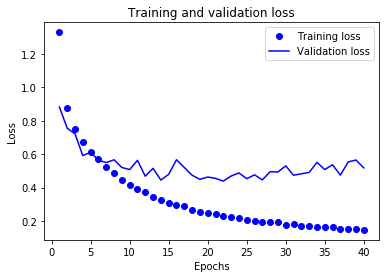

In [26]:
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [27]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()